In [51]:
#chargement des bibliothéques
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from sklearn.metrics import confusion_matrix

In [3]:
#chargement des données
df1=pd.read_csv("/content/drive/MyDrive/openfoodfacts_clean.csv")
df2=pd.read_csv("/content/drive/MyDrive/openfoodfacts_clean.xls")
#concaténation des données
data=pd.concat([df1,df2])

In [10]:
#exploration des données
print(data.head())
print(data.info())
print(data.describe())
print(data.shape)

                             Name  énergie  sucres      sel  \
0              Farine de blé noir      NaN     NaN      NaN   
1  Banana Chips Sweetened (Whole)   2243.0   14.29  0.00000   
2                         Peanuts   1941.0   17.86  0.63500   
3          Organic Salted Nut Mix   2540.0    3.57  1.22428   
4                 Organic Polenta   1552.0     NaN      NaN   

   acides_gras_saturés fruits‚_légumes_et_noix_-_séchés  fibres_alimentaires  \
0                  NaN                              NaN                  NaN   
1                28.57                              NaN                  3.6   
2                 0.00                              NaN                  7.1   
3                 5.36                              NaN                  7.1   
4                  NaN                              NaN                  5.7   

  Nutriscore  protéines  
0        NaN        NaN  
1       14.0        NaN  
2        0.0        NaN  
3       12.0        NaN  
4        N

In [9]:

#exploration des données 2
print(data.isnull().sum())
print(data. Name.duplicated().sum())
print(data.nunique())
print(data.describe(include='all'))



Name                                 17512
énergie                              60715
sucres                               76910
sel                                  66349
acides_gras_saturés                  92279
fruits‚_légumes_et_noix_-_séchés    358052
fibres_alimentaires                 135942
Nutriscore                          101309
protéines                           356089
dtype: int64
106787
Name                                251688
énergie                               4100
sucres                                4206
sel                                   5986
acides_gras_saturés                   2321
fruits‚_légumes_et_noix_-_séchés       116
fibres_alimentaires                   1164
Nutriscore                              60
protéines                              247
dtype: int64
             Name        énergie         sucres            sel  \
count      340964  297761.000000  281566.000000  292127.000000   
unique     251688            NaN            NaN            Na

In [11]:
# Identifier le pourcentage de données manquantes
missing_percentage = (data.isnull().sum() / len(data)) * 100
print("\n--- Pourcentage de Valeurs Manquantes ---")
print(missing_percentage.sort_values(ascending=False).head(5))


--- Pourcentage de Valeurs Manquantes ---
fruits‚_légumes_et_noix_-_séchés    99.881722
protéines                           99.334126
fibres_alimentaires                 37.922204
Nutriscore                          28.261027
acides_gras_saturés                 25.742030
dtype: float64


In [12]:
#suppression des colonnes
col_supprimer = ['fruits‚_légumes_et_noix_-_séchés ', 'protéines']
df= data.drop(columns=col_supprimer, errors='ignore')

In [14]:

# Fonction de conversion basée sur le barème OFFICIEL (Solides)
def score(valeur):
    # 1. Gestion des valeurs nulles/vides
    if pd.isna(valeur) or valeur == '':
        return None

    valeur_str = str(valeur).strip().upper()

    # 2. Si c'est déjà une lettre valide (A, B, C, D, E), on la garde
    if valeur_str in ['A', 'B', 'C', 'D', 'E']:
        return valeur_str

    # 3. Sinon, on essaie de convertir le chiffre en lettre
    try:
        score = float(valeur) # On convertit en nombre décimal

        # Application des SEUILS OFFICIELS
        if score <= -1:
            return 'A'
        elif score <= 2:
            return 'B'
        elif score <= 10:
            return 'C'
        elif score <= 18:
            return 'D'
        else:
            return 'E'  # Score >= 19

    except ValueError:
        # Si ce n'est ni une lettre connue, ni un nombre convertible -> Poubelle
        return None

# --- Application au DataFrame ---

print("Distribution AVANT nettoyage :")
print(df['Nutriscore'].value_counts())

# Application de la fonction
df['Nutriscore']= df['Nutriscore'].apply(score)

# Suppression des lignes qui n'ont pas pu être converties (None)
df = df.dropna(subset=['Nutriscore'])

print("\nDistribution APRÈS nettoyage (Barème Officiel appliqué) :")
print(df['Nutriscore'].value_counts().sort_index())

Distribution AVANT nettoyage :
Nutriscore
 0.0     14682
 14.0    13034
 1.0     12820
 2.0     12026
 13.0    10354
 11.0    10288
 12.0    10042
-1.0     10000
 3.0      9313
 15.0     8881
 20.0     7958
 10.0     7821
 16.0     7704
 4.0      7423
 9.0      7143
 19.0     7104
 21.0     7079
-2.0      7013
 17.0     6989
 18.0     6658
 8.0      5949
 5.0      5925
-3.0      5745
 6.0      5568
-6.0      5467
 23.0     5071
 22.0     5024
 7.0      5003
-4.0      4971
-5.0      4715
 24.0     4622
 25.0     3404
 26.0     3002
 27.0     1934
-7.0      1080
 28.0      769
-8.0       654
 C         635
 D         477
 E         449
 A         380
 B         370
-9.0       342
 29.0      319
 30.0      215
-10.0      199
-11.0      110
 33.0      107
 31.0       87
 32.0       72
-12.0       51
 35.0       38
-13.0       25
 34.0       22
 36.0       19
-14.0        5
 40.0        4
 37.0        4
 38.0        1
-15.0        1
Name: count, dtype: int64

Distribution APRÈS nettoyage (B

In [25]:
#verification
print(df.shape)
df.head()

(257167, 7)


,Name,énergie,sucres,sel,acides_gras_saturés,fibres_alimentaires,Nutriscore
1,Banana Chips Sweetened (Whole),2243.0,14.29,0.00000,28.57,3.6,D
2,Peanuts,1941.0,17.86,0.63500,0.00,7.1,B
3,Organic Salted Nut Mix,2540.0,3.57,1.22428,5.36,7.1,D
7,Organic Muesli,1833.0,15.62,0.13970,4.69,9.4,C
12,Zen Party Mix,2230.0,3.33,1.60782,5.00,6.7,D


In [24]:
#remplacement des valeurs nulles
import pandas as pd

# 1. colonnes à nettoyer
colonnes_nutriments = [
    'fibres_alimentaires',
    'acides_gras_saturés',
    'sucres',
    'énergie',
    'sel'
]

cols_presentes = [c for c in colonnes_nutriments if c in df.columns]

# 2. Imputation par la Médiane
#  calcul de la médiane pour chaque colonne et on remplit les trous avec
print("--- Remplacement des valeurs manquantes par la Médiane ---")
for col in cols_presentes:
    mediane = df[col].median()
    df[col] = df[col].fillna(mediane)
    print(f"Colonne '{col}' : NaN remplacés par la médiane ({mediane})")

# 3. Gestion de la colonne 'Name' (Texte)
# Pour le nom, on ne peut pas calculer de médiane, on met "Inconnu"
if 'Name' in df.columns:
    df['Name'] = df['Name'].fillna("Nom Inconnu")

# 4. Vérification finale
print("\n--- Vérification des Valeurs Manquantes Restantes ---")
print(df.isnull().sum())

--- Remplacement des valeurs manquantes par la Médiane ---
Colonne 'fibres_alimentaires' : NaN remplacés par la médiane (1.5)
Colonne 'acides_gras_saturés' : NaN remplacés par la médiane (1.79)
Colonne 'sucres' : NaN remplacés par la médiane (5.0)
Colonne 'énergie' : NaN remplacés par la médiane (1155.0)
Colonne 'sel' : NaN remplacés par la médiane (0.62)

--- Vérification des Valeurs Manquantes Restantes ---
Name                   0
énergie                0
sucres                 0
sel                    0
acides_gras_saturés    0
fibres_alimentaires    0
Nutriscore             0
dtype: int64


In [28]:
#corrélation


# 1. Création d'une copie pour l'analyse (pour ne pas toucher au dataset original)
df_corr = df.copy()

# 2. Encodage : A=0, B=1, C=2, D=3, E=4
mapping = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
df_corr['grade_numerique'] = df_corr['Nutriscore'].map(mapping)

# 3. Sélection des colonnes numériques uniquement
cols_numeriques = df_corr.select_dtypes(include=['float64', 'int64', 'int32']).columns

# Calcul de la matrice de corrélation
correlation_matrix = df_corr[cols_numeriques].corr()

# Affichage des corrélations avec la cible (grade_numerique)
print("--- Corrélation avec le Nutri-Score (Plus c'est haut, plus c'est E) ---")
print(correlation_matrix['grade_numerique'].sort_values(ascending=False))

--- Corrélation avec le Nutri-Score (Plus c'est haut, plus c'est E) ---
grade_numerique        1.000000
acides_gras_saturés    0.566651
énergie                0.491832
sucres                 0.409792
sel                    0.006771
fibres_alimentaires   -0.001752
Name: grade_numerique, dtype: float64


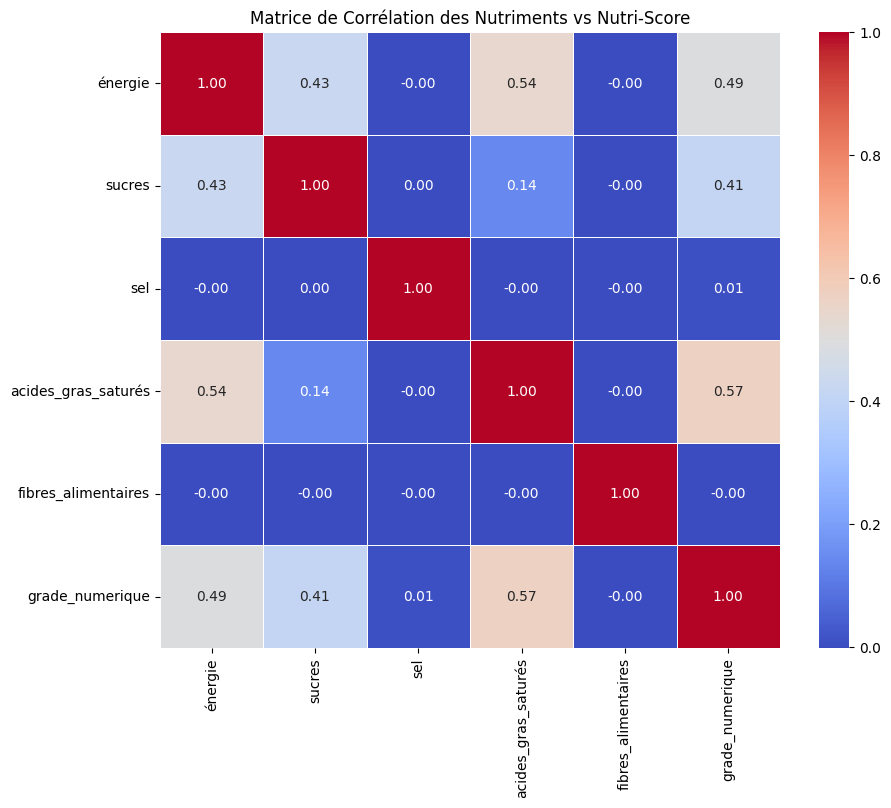

In [29]:
#visualisation du heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,     # Affiche les chiffres dans les cases
    cmap='coolwarm', # Bleu = Négatif (Bon), Rouge = Positif (Mauvais)
    fmt=".2f",      # 2 chiffres après la virgule
    linewidths=0.5
)
plt.title("Matrice de Corrélation des Nutriments vs Nutri-Score")
plt.show()

In [35]:
df.head()

,Name,énergie,sucres,sel,acides_gras_saturés,fibres_alimentaires,Nutriscore
1,Banana Chips Sweetened (Whole),2243.0,14.29,0.00000,28.57,3.6,D
2,Peanuts,1941.0,17.86,0.63500,0.00,7.1,B
3,Organic Salted Nut Mix,2540.0,3.57,1.22428,5.36,7.1,D
7,Organic Muesli,1833.0,15.62,0.13970,4.69,9.4,C
12,Zen Party Mix,2230.0,3.33,1.60782,5.00,6.7,D


In [37]:
#supression de la colonne name
df=df.drop(columns='Name')

In [39]:
#definition de features
X=df.drop(columns='Nutriscore')
y=df['Nutriscore']

In [40]:
#encodage de Y
mapping_nutriscore = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4}
y_encoded = y.map(mapping_nutriscore)

In [43]:
#séparation du train/test
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)
print("\n--- Séparation Terminée ---")
print(f"Données d'entraînement (Train) : {X_train.shape}")
print(f"Données de test (Test)         : {X_test.shape}")


--- Séparation Terminée ---
Données d'entraînement (Train) : (205733, 5)
Données de test (Test)         : (51434, 5)


In [45]:
# Modélisation
#Fonction d'Entraînement et d'Évaluation
def train_and_evaluate(name, model, X_train, y_train, X_test, y_test, target_names):
    """Entraîne un modèle, fait des prédictions et affiche les métriques."""
    start_time = time.time()

    print(f"\n Démarrage de l'entraînement : {name}...")

    # Entraînement
    model.fit(X_train, y_train)

    # Prédiction sur le jeu de test
    y_pred = model.predict(X_test)

    # Évaluation
    accuracy = accuracy_score(y_test, y_pred)
    training_time = time.time() - start_time

    print(f" Terminé en {training_time:.2f} secondes.")
    print("-" * 50)
    print(f"Précision Globale (Accuracy) : {accuracy:.4f}")

    # Rapport de classification détaillé
    print("\n--- Rapport de Classification ---")
    print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

    return model, accuracy, training_time

In [48]:
# Définition des Modèles
models_list = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'Logistic Regression': LogisticRegression(max_iter=500, random_state=42, multi_class='multinomial', solver='lbfgs', n_jobs=-1),
    'K-Nearest Neighbors (KNN)': KNeighborsClassifier(n_neighbors=5, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(
        objective='multi:softmax',
        num_class=5,
        n_estimators=100,
        learning_rate=0.1,
        eval_metric='mlogloss',
        random_state=42,
        n_jobs=-1,

    )
}


In [49]:

# Définition des étiquettes (labels) pour le rapport
target_names = ['A', 'B', 'C', 'D', 'E']
# Entraînement et Vérification (Modèle par Modèle)
all_results = {}
trained_models = {}

for name, model in models_list.items():
    trained_model, accuracy, training_time = train_and_evaluate(
        name,
        model,
        X_train, y_train,
        X_test, y_test,
        target_names
    )

    all_results[name] = {'Accuracy': accuracy, 'Time': training_time}
    trained_models[name] = trained_model




 Démarrage de l'entraînement : Random Forest...
 Terminé en 38.93 secondes.
--------------------------------------------------
Précision Globale (Accuracy) : 0.9115

--- Rapport de Classification ---
              precision    recall  f1-score   support

           A       0.91      0.90      0.91      8120
           B       0.82      0.84      0.83      8081
           C       0.89      0.89      0.89     11044
           D       0.94      0.95      0.94     14852
           E       0.97      0.95      0.96      9337

    accuracy                           0.91     51434
   macro avg       0.91      0.91      0.91     51434
weighted avg       0.91      0.91      0.91     51434


 Démarrage de l'entraînement : Logistic Regression...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


 Terminé en 100.72 secondes.
--------------------------------------------------
Précision Globale (Accuracy) : 0.4748

--- Rapport de Classification ---
              precision    recall  f1-score   support

           A       0.70      0.44      0.54      8120
           B       0.35      0.10      0.15      8081
           C       0.34      0.31      0.32     11044
           D       0.44      0.69      0.54     14852
           E       0.59      0.69      0.63      9337

    accuracy                           0.47     51434
   macro avg       0.48      0.44      0.44     51434
weighted avg       0.47      0.47      0.45     51434


 Démarrage de l'entraînement : K-Nearest Neighbors (KNN)...
 Terminé en 1.80 secondes.
--------------------------------------------------
Précision Globale (Accuracy) : 0.7684

--- Rapport de Classification ---
              precision    recall  f1-score   support

           A       0.76      0.82      0.79      8120
           B       0.65      0.68    

In [50]:
# Affichage du tableau de synthèse
print("\n" + "="*60)
print("             RÉSUMÉ FINAL DES PERFORMANCES")
print("="*60)
final_summary = pd.DataFrame(all_results).T
final_summary['Rank'] = final_summary['Accuracy'].rank(ascending=False).astype(int)

print(final_summary.sort_values(by='Accuracy', ascending=False))


             RÉSUMÉ FINAL DES PERFORMANCES
                           Accuracy        Time  Rank
Random Forest              0.911459   38.933903     1
XGBoost                    0.870747   14.951804     2
K-Nearest Neighbors (KNN)  0.768383    1.802139     3
Logistic Regression        0.474764  100.718218     4


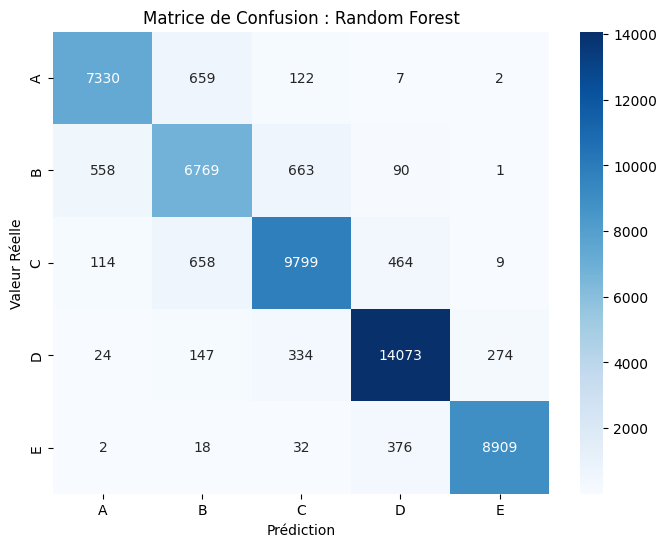

In [52]:
# 1. Sélection du modèle champion
rf_model = trained_models['Random Forest']
y_pred_rf = rf_model.predict(X_test)

# 2. Calcul de la Matrice de Confusion
cm = confusion_matrix(y_test, y_pred_rf)

# 3. Visualisation
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=target_names, # A, B, C, D, E prédits
    yticklabels=target_names  # A, B, C, D, E réels
)
plt.title('Matrice de Confusion : Random Forest')
plt.xlabel('Prédiction')
plt.ylabel('Valeur Réelle')
plt.show()